#**[Pedro] Analytics Engineer Take Home Assignment**

#Notes

Hi Yuan,

To make the Assignment submission possible I created this notebook replicating the HEX one. As the StackOverflow database was open, I built the queries directly in BigQuery, exported the tables and saved them in this environment to create the charts and complement the analysis.

Possibly the values will not be the same as using HEX, because I do not know exactly what filters had been applied to the database there.

Anyway, the queries used to create the tables are available below and just run them in Bigquery and they will generate the same tables saved here.

Colab does not have a built-in tool for creating charts, so I took the liberty of generating them in Python.

That's it.

#How to run it

Just click to run in order, with one point in mind!

All queries were written in Bigquery and can run natively there, since the databases are open.

However, this requires linking the account to Google Colab, which can cause problems. 

To get around the issue, in the code cell below the cell that contains the Bigquery query I inserted the command to read a *.csv table directly from Google Drive.

This table is identical to the one obtained in the Bigquery. But it solves any problem that may arise for linking the accounts

# Introduction
Welcome to the practical assessment for the Analytics Engineer role at Toggl.


This exercise will help us assess your ability to translate business questions into SQL queries and visualisations that provide answers. You will directly provide your work in this editable SQL notebook. Instructions for how to edit this notebook can be found here: https://learn.hex.tech/quickstart/hex-101#5-use-sql-cells


This notebook is connected to a [public StackOverflow dataset](https://cloud.google.com/blog/products/gcp/google-bigquery-public-datasets-now-include-stack-overflow-q-a), downloaded as CSVs for faster querying. The database engine is DuckDB. You can find documentation for its syntax here: https://duckdb.org/docs/sql/functions/overview. You may find that some columns need to be casted into the right type before using them.


The exercise consists of a series of business questions. Your task will be to design and write a query
or queries, and provide visualisation of the resulting data that will answer the
business question. You may add additional SQL blocks to a question as necessary.
The questions range from easy to difficult. It is not expected that you will be able to
complete all the questions, only that the questions that you do complete realistically
reflect your ability.


Your answers will be assessed according to the following criteria, in order of importance:
1. Correctness and accuracy; in this exercise, as in real life, it's better to have no data
than misleading data
2. Design and presentation; how well does the structure of the data address the
specific business question as asked, and how easy is it to understand the data as
presented (labelling, layout, etc)?
3. Query structure and formatting; does the organisation of the query and any CTEs
follow a logical flow, is the code easy to read, and is the intent clear to the reader?
4. Difficulty; more weight will be given to more challenging questions


To start work, click on the "Logic" toggle at the top of the page and start editing. To save your work (when you are finished, or to
preserve work in progress), press the "Publish" button.

_Note: you may prefer to compose your code in your favourite programming editor and
copy/paste into the notebook, rather than rely on the editor built into the SQL notebook_

#Dataset

The dataset for this exercise was taken from the publicly available StackOverflow BigQuery dataset. StackOverflow is a question and answer website where programmers ask/answer questions and share knowledge. Users can post questions, answer posted questions, comment on questions or answers, and up/downvote questions/answers/comments.


#Question 1
How has the rate of users asking questions changed over the past few months?

## Answer 1

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [95]:
project_id = 'stackoverflow-test-toggl'

from google.cloud import bigquery
import pandas as pd

client = bigquery.Client(project=project_id)

df1 = client.query('''
  --How has the rate of users asking questions changed over the past few months?

select count(distinct(owner_user_id)) as Users_Making_Questions, date_trunc(creation_date, month) as Creation_month, --DATE_TRUNC(CAST('2021-01-01' AS DATE), MONTH) AS month,
from
  `bigquery-public-data.stackoverflow.posts_questions`
where creation_date >= '2019-01-01' and creation_date < '2022-03-01'
group by 2
order by 2 desc
''').to_dataframe()

df1.head()

,Users_Making_Questions,Creation_month
0,112505,2022-02-01 00:00:00+00:00
1,104088,2022-01-01 00:00:00+00:00
2,99240,2021-12-01 00:00:00+00:00
3,104666,2021-11-01 00:00:00+00:00
4,103382,2021-10-01 00:00:00+00:00


In [96]:
#Importing data from URL (my google drive), but the table is the same as in the query above

import pandas as pd

url ='https://drive.google.com/file/d/18DuUSX6cOue4nH-f1Ho_RgUaxZeIvRTT/view?usp=sharing'
url ='https://drive.google.com/uc?id=' + url.split('/')[-2]
df1 = pd.read_csv(url)

df1.head()

,Users_Making_Questions,Creation_month
0,112505,2022-02-01 00:00:00 UTC
1,104088,2022-01-01 00:00:00 UTC
2,99240,2021-12-01 00:00:00 UTC
3,104666,2021-11-01 00:00:00 UTC
4,103382,2021-10-01 00:00:00 UTC


In [98]:
m = df1['Users_Making_Questions'].mean()
c = len(df1.index)

print('the average number of users asking questions in the last ' + str(c) +' months was ' + str(m) +' users/month')

the average number of users asking questions in the last 38 months was 104940.21052631579 users/month


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37],
 <a list of 38 Text major ticklabel objects>)

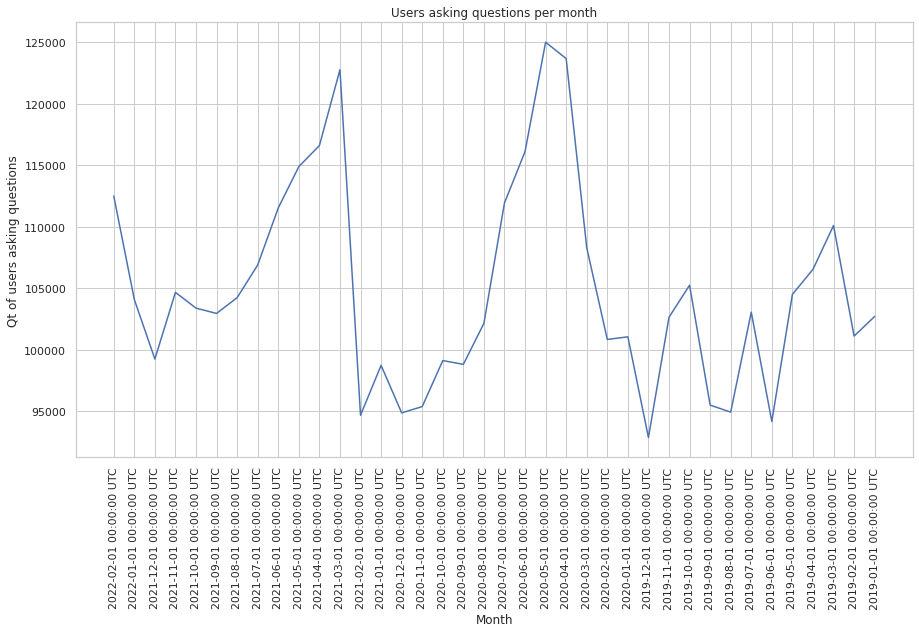

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
sns.lineplot(x = "Creation_month", y = "Users_Making_Questions", data=df1)
plt.xlabel("Month")
plt.ylabel("Qt of users asking questions")
plt.title("Users asking questions per month")
plt.xticks(rotation=90)

# Question 2
How has the participation rate (questions, answers, comments) of users changed in the last 3 months, compared with the period before?

## Answer 2

I separated the amount of users who created questions, answers or comments in the current quarter (Q0) and compared it to the previous quarter (Q-1).

In [99]:
df2 = client.query('''

-- I intended to use the DATE_ADD function to group the quarters more efficiently, but the function did not behave the way I expected in Bigquery,
-- so because it was only comparing two periods I used UNION ALL.
-- But I do not consider this the best practice
-- the end date selected was 2022-03-01 because the month of March was not complete in the base made available in bigquery, which generated an "unfair" comparison with the previous quarter

with Quarters as
(select count(distinct(owner_user_id)) as Participation, 'questions' as Item, 'Q0' as Quarter
from
  `bigquery-public-data.stackoverflow.posts_questions`
where creation_date >= '2021-12-01' and creation_date < '2022-03-01'
--where creation_date between DATE_ADD(creation_date, INTERVAL -180 DAY) and DATE_ADD(creation_date, INTERVAL -90 DAY)

UNION ALL

select count(distinct(owner_user_id)) as Participation, 'answers' as Item, 'Q0' as Quarter
from
  `bigquery-public-data.stackoverflow.posts_answers`
where creation_date >= '2021-12-01' and creation_date < '2022-03-01'
--where creation_date > DATE_ADD(creation_date, INTERVAL -90 DAY)

UNION ALL

select count(distinct(user_id)) as Participation, 'comments' as Item, 'Q0' as Quarter
from
  `bigquery-public-data.stackoverflow.comments`
where creation_date >= '2021-12-01' and creation_date < '2022-03-01'
--where creation_date > DATE_ADD(creation_date, INTERVAL -90 DAY)

UNION ALL

select count(distinct(owner_user_id)) as Participation, 'questions' as Item, 'Q-1' as Quarter
from
  `bigquery-public-data.stackoverflow.posts_questions`
where creation_date >= '2021-09-01' and creation_date < '2022-12-01'
--where creation_date > DATE_ADD(creation_date, INTERVAL -180 DAY) and creation_date < DATE_ADD(creation_date, INTERVAL -90 DAY)

UNION ALL

select count(distinct(owner_user_id)) as Participation, 'answers' as Item, 'Q-1' as Quarter
from
  `bigquery-public-data.stackoverflow.posts_answers`
where creation_date >= '2021-09-01' and creation_date < '2022-12-01'
--where creation_date > DATE_ADD(creation_date, INTERVAL -180 DAY) and creation_date < DATE_ADD(creation_date, INTERVAL -90 DAY)

UNION ALL

select count(distinct(user_id)) as Participation, 'comments' as Item, 'Q-1' as Quarter
from
  `bigquery-public-data.stackoverflow.comments`
where creation_date >= '2021-09-01' and creation_date < '2022-12-01'
--where creation_date > DATE_ADD(creation_date, INTERVAL -180 DAY) and creation_date < DATE_ADD(creation_date, INTERVAL -90 DAY)

)

select * from Quarters
''').to_dataframe()

print(df2)

   Participation       Item Quarter
0         238719   comments      Q0
1         270016    answers     Q-1
2         265820  questions      Q0
3         406681   comments     Q-1
4         476178  questions     Q-1
5         151352    answers      Q0


In [100]:
#Importing data from URL (my google drive), but the table is the same as in the query above

import pandas as pd

url = 'https://drive.google.com/file/d/1BfX7vmMzuSo1OfrMnusonVYRUS-6uubC/view?usp=sharing'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df2 = pd.read_csv(url)

df2.head()

,Participation,Item,Quarter
0,151352,answers,Q0
1,476178,questions,Q-1
2,406681,comments,Q-1
3,270016,answers,Q-1
4,265820,questions,Q0


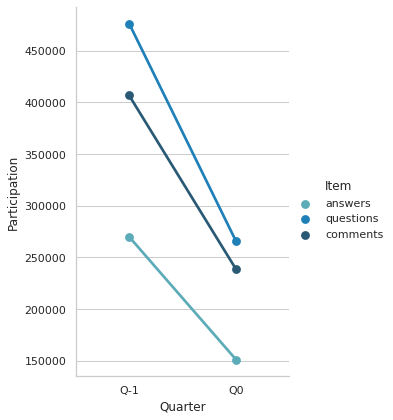

In [106]:
sns.set_theme(style="whitegrid")
sns.catplot(data=df2, x='Quarter', y='Participation', hue='Item', order=['Q-1','Q0'], capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75)
#The order of the factors in the graph below can be changed in the function above


We can see a reduction in the amount of comments, questions and answers compared to the previous quarter

# Question 3
How does the reputation growth rate of users who answer questions frequently compare with those who do so less frequently?

## Answer 3

For this solution I separated in a table the reputation and responses per user and identified the growth rate using a simple linear regression model.

The angular coefficient of the model was significant and corresponds to the growth rate.

In [8]:
df3 = client.query('''
select a.display_name Name, a.reputation Reputation, b.answers Answers
from
  `bigquery-public-data.stackoverflow.users` as a
join (select count(id) as answers, owner_user_id
from
  `bigquery-public-data.stackoverflow.posts_answers`
  group by 2) as b ON a.id = b.owner_user_id
where creation_date > '2019-01-01'
''').to_dataframe()

df3.head()

,Name,Reputation,Answers
0,red_menace,2702,164
1,Halil Ural,14,2
2,Vladimir Rodichev,353,26
3,Vishwajeet Singh,131,1
4,deonardo_licaprio,154,5


In [ ]:
#Importing data from URL (my google drive), but the table is the same as in the query above

import pandas as pd

url = 'https://drive.google.com/file/d/1_RiYPv1LSdnfMGjMo4dXk55sI_KcktHE/view?usp=sharing'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df3 = pd.read_csv(url)

df3.head()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


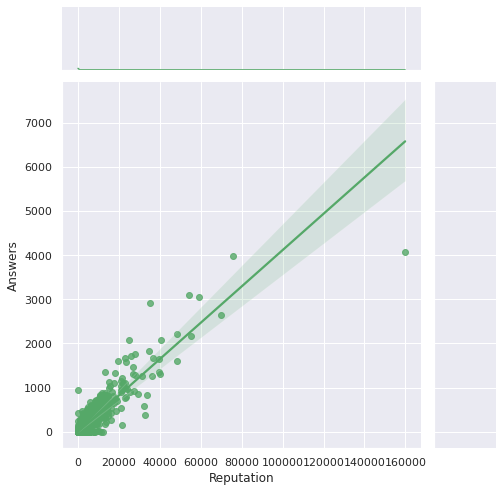

In [67]:
sns.set(style = "darkgrid")
tips = sns.load_dataset("tips")
color = sns.color_palette()[2]
sns.jointplot("Reputation", 
                  "Answers", 
                  data = df3, 
                  kind = "reg", 
                  color = color, 
                  size = 7)

In [11]:
import statsmodels as st
import statsmodels.formula.api as sm
import pandas as pd

modeldf = pd.DataFrame(df3)
result = sm.ols(formula="Reputation ~ Answers", data=df3).fit()
print(result.params)
print(result.summary())

Intercept    -6.937978
Answers      19.916064
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             Reputation   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                 2.162e+06
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:39:54   Log-Likelihood:            -3.2494e+06
No. Observations:              478294   AIC:                         6.499e+06
Df Residuals:                  478292   BIC:                         6.499e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

The result of the adjustment shows that **the average growth rate of Reputation is 1 point for every 19.91 answers given by the user**.

The adjustment coefficient R² of 0.819 indicates a good quality fit, the p-value of t for the responses indicates the significance of the variable on Reputation (that the impact is not zero).

The rest of the information is just details for model validation, important if further investigation is initiated.

# Question 4
In terms of quality of answers (as measured by the number of favorites and comments received), which monthly cohorts of registered users produced the best answers?

## Answer 4

We have two three ways to analyze this question. The first is by considering the average number of bookmarks received per response per user, the second only the number of comments received per response per user and the third is by using a weighted average of bookmarks and comments per response per user.

It is important to use the average as a measure of quality because if we use only absolute values, a user who made few replies but always with good ratings could be considered of less quality than a user who receives few comments and bookmarks in his replies but publishes many replies.

Example: User1: 230 comments in 23 replies, User2: 300 comments in 400 replies.
Which user produced the best quality comments? I believe it is User1

The cohort concept used is the month of registration: https://en.wikipedia.org/wiki/Cohort_(statistics)

Info: the favorites column is empty in the post_answers table, so it is not included in the final analysis

In [12]:
df4 = client.query('''

select AVG(Comments) as Quality_rate, date_trunc(creation_date, month) as user_creation_month
from
(
select
AVG(cast(a.favorite_count as NUMERIC)) as Favorites, -- in this subquery we notice that the column favorite_count is empty in the "post_answers" table, so it is not inserted in the final quality indicator
AVG(a.comment_count) as Comments,
a.owner_user_id as owner_user_id,
b.creation_date as creation_date
from
 `bigquery-public-data.stackoverflow.posts_answers` as a
join
 `bigquery-public-data.stackoverflow.users` as b
on a.owner_user_id = b.id
where b.creation_date > '2019-01-01'
group by 3, 4
)
group by 2
order by 2 asc

''').to_dataframe()

df4.head()

,Quality_rate,user_creation_month
0,0.527468,2019-01-01 00:00:00+00:00
1,0.513515,2019-02-01 00:00:00+00:00
2,0.518887,2019-03-01 00:00:00+00:00
3,0.508108,2019-04-01 00:00:00+00:00
4,0.484962,2019-05-01 00:00:00+00:00


In [69]:
#Importing data from URL (my google drive), but the table is the same as in the query above

import pandas as pd

url = 'https://drive.google.com/file/d/1cTXGvXE5R4yWyDOQXC_tZKjq1AplYycc/view?usp=sharing'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df4 = pd.read_csv(url)

df4.head()

,Quality_rate,user_creation_month
0,0.527468,2019-01-01 00:00:00 UTC
1,0.513515,2019-02-01 00:00:00 UTC
2,0.518887,2019-03-01 00:00:00 UTC
3,0.508108,2019-04-01 00:00:00 UTC
4,0.484962,2019-05-01 00:00:00 UTC


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]), <a list of 39 Text major ticklabel objects>)

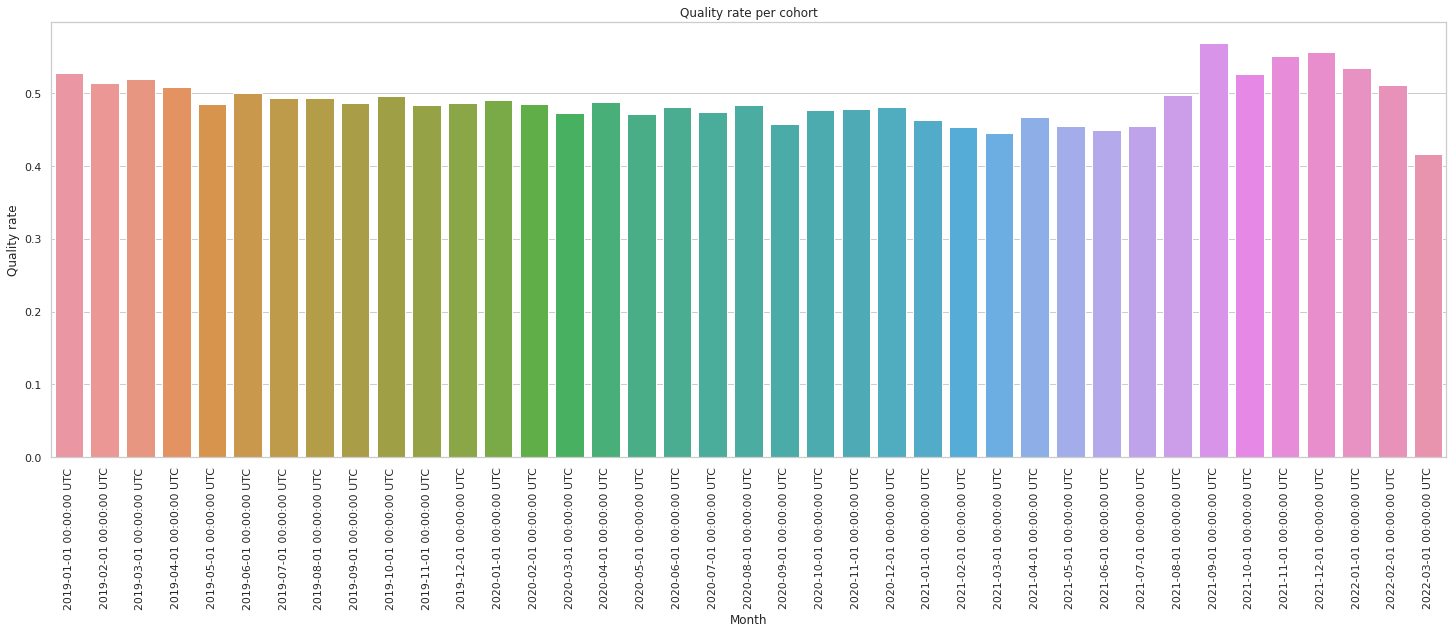

In [107]:
df4 = df4.sort_values(['user_creation_month'])
sns.set_theme(style="whitegrid")
plt.figure(figsize=(25,8))
sns.barplot(x = "user_creation_month", y = "Quality_rate", data=df4)
plt.xlabel("Month")
plt.ylabel("Quality rate")
plt.title("Quality rate per cohort")
plt.xticks(rotation=90)

In [71]:
df4 = df4.sort_values(['Quality_rate'], ascending=False)
df4.head()

,Quality_rate,user_creation_month
32,0.568316,2021-09-01 00:00:00 UTC
35,0.556232,2021-12-01 00:00:00 UTC
34,0.550319,2021-11-01 00:00:00 UTC
36,0.533711,2022-01-01 00:00:00 UTC
0,0.527468,2019-01-01 00:00:00 UTC


In [74]:
max_qualityrate_month = df4.loc[1, 'user_creation_month']
#max_qualityrate_month = max_qualityrate_month.strftime('%m/%Y')

print('The (monthly) cohort with the best user quality rate was ' + str(max_qualityrate_month))

The (monthly) cohort with the best user quality rate was 2019-02-01 00:00:00 UTC


# Question 5
What category (tag) of questions are driving the most engagement (questions, answers, comments, favorites), and how has this changed over time?

## Answer 5

In this query we consider engagement as the sum of questions, answers, comments, and favorites in a given category (tag)

There are two subqueries that generate the final table.
The first one seeks to generate the split tags and truncate the creation dates by month.
The second raises the total of questions, comments, replies, favorites, and total engagement (sum).

The final table generates a table with the engagement history of the 10 most used tags.

In [92]:

df5 = client.query('''

with tags as (
  -- table with all engagement vars
  select tag, COUNT(*) total_questions, datas, sum(comment) comment, sum(answer) answer, sum(favorite) favorite, (sum(comment) + sum(answer) + sum(favorite))+count(*) engagement
FROM_HEX (
  -- spliting tags
  select SPLIT(tags, '|') tags, date_trunc(creation_date, month) as datas, comment_count comment, answer_count answer, favorite_count favorite
  from `bigquery-public-data.stackoverflow.posts_questions` a
  where EXTRACT(YEAR from creation_date)>=2019
), UNNEST(tags) tag
group by 1, 3
order by 2 DESC), toptags as (select tag, sum(total_questions) total from tags group by tag order by 2 desc limit 10)

--Generates a table with the engagement history of the 10 most used tags (for this the inner join was performed)
select t.* from tags t
inner join toptags tt
on t.tag = tt.tag
where datas < '2022-03-01' -- the end date selected was 2022-03-01 because the month of March was not complete in the base made available in bigquery, which generated an "unfair" comparison with the previous months
order by tag asc

''').to_dataframe()

df5.head()

,tag,total_questions,datas,comment,answer,favorite,engagement
0,android,6006,2021-07-01 00:00:00+00:00,8442,4704,730,19882
1,android,5067,2020-11-01 00:00:00+00:00,8839,5250,914,20070
2,android,5762,2021-08-01 00:00:00+00:00,8278,4415,516,18971
3,android,6767,2020-01-01 00:00:00+00:00,14239,7864,1386,30256
4,android,5563,2022-02-01 00:00:00+00:00,7454,3149,256,16422


In [94]:
#Importing data from URL (my google drive), but the table is the same as in the query above

import pandas as pd

url = 'https://drive.google.com/file/d/1sZF3-1kZ3pndXbL5J_023Zca2k0CnMLm/view?usp=sharing'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df5 = pd.read_csv(url)

df5.head()

,tag,total_questions,datas,comment,answer,favorite,engagement
0,android,4557,2021-02-01 00:00:00 UTC,8191,4488,561,17797
1,android,6012,2019-12-01 00:00:00 UTC,12467,6994,1323,26796
2,android,6958,2019-06-01 00:00:00 UTC,14134,8488,1746,31326
3,android,8043,2019-07-01 00:00:00 UTC,16977,9742,1814,36576
4,android,6918,2019-10-01 00:00:00 UTC,14143,8183,1309,30553


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37],
 <a list of 38 Text major ticklabel objects>)

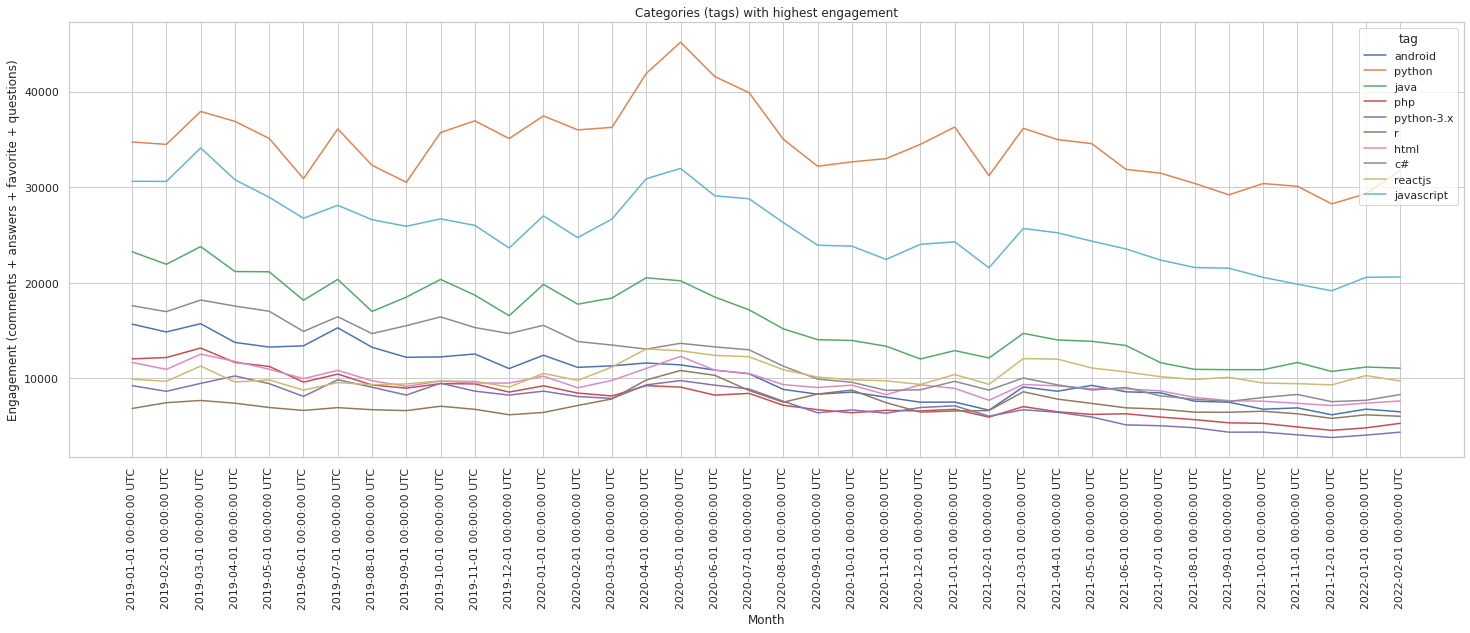

In [78]:
df5 = df5.sort_values(['datas'])

sns.set_theme(style="whitegrid")
plt.figure(figsize=(25,8))
sns.lineplot(x = "datas", y = "engagement", hue = 'tag', data=df5)
plt.xlabel("Month")
plt.ylabel("Engagement (comments + answers + favorite + questions)")
plt.title("Categories (tags) with highest engagement")
plt.xticks(rotation=90)

The graph above shows the fluctuation of engagement over time for the 10 most popular categories (tags).

# Question 6
Is the problem of unhelpful users (define this yourself) getting better or worse?

## Answer 6

Unhelpful users definition: Users who post replies but have a negative average score.

A user who never posts doesn't help, but also doesn't hinder, but users who post and their questions have a negative score generate a more negative impact on the community or for the solution of the question itself.

Since those who follow the answer of an unhelpful user tend to waste time with an incorrect solution.

The unhelpful user is cargorized by period (in this case month) because he can change his attitude over time.

After generating the table with each of them, the behavior over time is analyzed.


In [49]:
df6 = client.query('''

with unhelpful as (
  -- table with the average score calculation and selection of users with negative average score in the period
select owner_user_id, AVG(score) as Score, count(id) as Answers_posted, creation_month
from
  (
    -- table that selects the question, the user, score and truncates the date
    select owner_user_id, score, id, date_trunc(creation_date, month) as creation_month
    from
      `bigquery-public-data.stackoverflow.posts_answers`
where creation_date > '2019-01-01') 
group by 1, 4
having Score < 0
order by Score asc
)

-- unhelpful users over time
select count(owner_user_id) as unhelpful_users, creation_month
from unhelpful
where creation_month < '2022-03-01' -- the end date selected was 2022-03-01 because the month of March was not complete in the base made available in bigquery, which generated an "unfair" comparison with the previous months
group by 2

''').to_dataframe()

df6.head()

,unhelpful_users,creation_month
0,2777,2019-01-01 00:00:00+00:00
1,2439,2021-04-01 00:00:00+00:00
2,2413,2021-05-01 00:00:00+00:00
3,2521,2021-06-01 00:00:00+00:00
4,2272,2022-01-01 00:00:00+00:00


In [79]:
#Importing data from URL (my google drive), but the table is the same as in the query above

import pandas as pd

url='https://drive.google.com/file/d/1KFuzq_B2_iiPbb36sLVLHxV4N589wzP9/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df6 = pd.read_csv(url)

df6.head()

,unhelpful_users,creation_month
0,2272,2022-01-01 00:00:00 UTC
1,2090,2022-02-01 00:00:00 UTC
2,2777,2019-01-01 00:00:00 UTC
3,2558,2019-10-01 00:00:00 UTC
4,2725,2019-11-01 00:00:00 UTC


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37],
 <a list of 38 Text major ticklabel objects>)

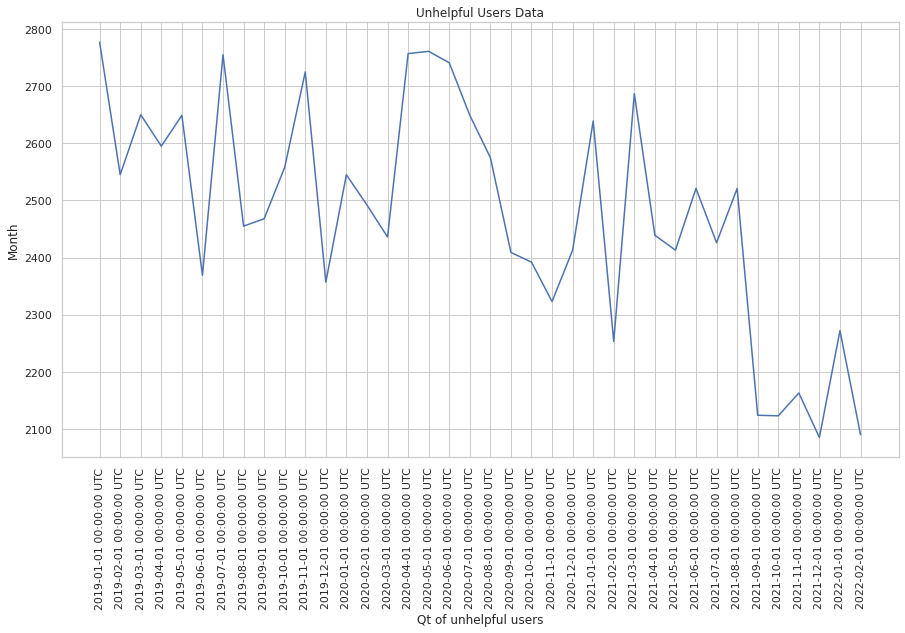

In [81]:
# Ordering the dataset
df6 = df6.sort_values(['creation_month'])

#Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
sns.lineplot(x = "creation_month", y = "unhelpful_users", data=df6)
plt.xlabel("Qt of unhelpful users")
plt.ylabel("Month")
plt.title("Unhelpful Users Data")
plt.xticks(rotation=90)

Great news, the rate of Unhelpful users is decreasing.

# Question 7
What are the top few topics that are popular and trending but are not being answered?

## Answer 7

For this question I have created an answer rate for each category (tag) that takes into account the number of questions asked in relation to the number of answers.

When this ratio is less than 1 it means that the number of answers does not cover the total number of questions (at all). The higher the ratio, the higher the response rate in relation to the questions.

Decreases in the ratio or popular topics with low ratios may indicate the need for engagement or promotion to improve the response rate, which would generate more satisfied users.

We select popular topics based on engagement measures (total comments, questions, favorites and replies).

In [60]:
df7 = client.query('''

with tags as (select tag, COUNT(*) total_questions, datas, sum(comment) comment, sum(answer) answer, sum(favorite) favorite, sum(comment + answer + favorite)+count(*) engagement
from (
  select SPLIT(tags, '|') tags, date_trunc(creation_date, month) as datas, comment_count comment, answer_count answer, favorite_count favorite
  from `bigquery-public-data.stackoverflow.posts_questions` a
  where EXTRACT(YEAR from creation_date)>=2019
), UNNEST(tags) tag
group by 1, 3
order by 2 desc), toptags as (select tag, sum(total_questions) total from tags group by tag order by 2 desc limit 10)

select t.*, IEEE_DIVIDE(answer, t.total_questions) as ratio from tags t
inner join toptags tt
on t.tag = tt.tag
where datas < '2022-01-01' -- the end date selected was 2022-03-01 because the month of March was not complete in the base made available in bigquery, which generated an "unfair" comparison with the previous months
order by tag asc

''').to_dataframe()

df7.head()

,tag,total_questions,datas,comment,answer,favorite,engagement,ratio
0,android,5129,2021-10-01 00:00:00+00:00,7692,3574,450,6774,0.696822
1,android,5478,2020-10-01 00:00:00+00:00,8696,5721,916,8571,1.044359
2,android,5240,2021-01-01 00:00:00+00:00,9819,5427,596,7523,1.035687
3,android,6360,2020-02-01 00:00:00+00:00,12554,7286,1219,11156,1.145597
4,android,7072,2019-05-01 00:00:00+00:00,14523,8367,1689,13278,1.183117


In [84]:
#Importing data from URL (my google drive), but the table is the same as in the query above

import pandas as pd

url='https://drive.google.com/file/d/1r0LrfSRk9em8yaaQcGzZjP1Uto-zyM6P/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df7 = pd.read_csv(url)

df7.head()

,tag,total_questions,datas,comment,answer,favorite,engagement,ratio
0,android,6716,2019-11-01 00:00:00 UTC,14115,7966,1453,12555,1.186123
1,android,6552,2021-05-01 00:00:00 UTC,9454,4990,767,9271,0.761600
2,android,7212,2019-04-01 00:00:00 UTC,14290,8711,1734,13764,1.207848
3,android,5240,2021-01-01 00:00:00 UTC,9819,5427,596,7523,1.035687
4,android,6360,2020-02-01 00:00:00 UTC,12554,7286,1219,11156,1.145597


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35],
 <a list of 36 Text major ticklabel objects>)

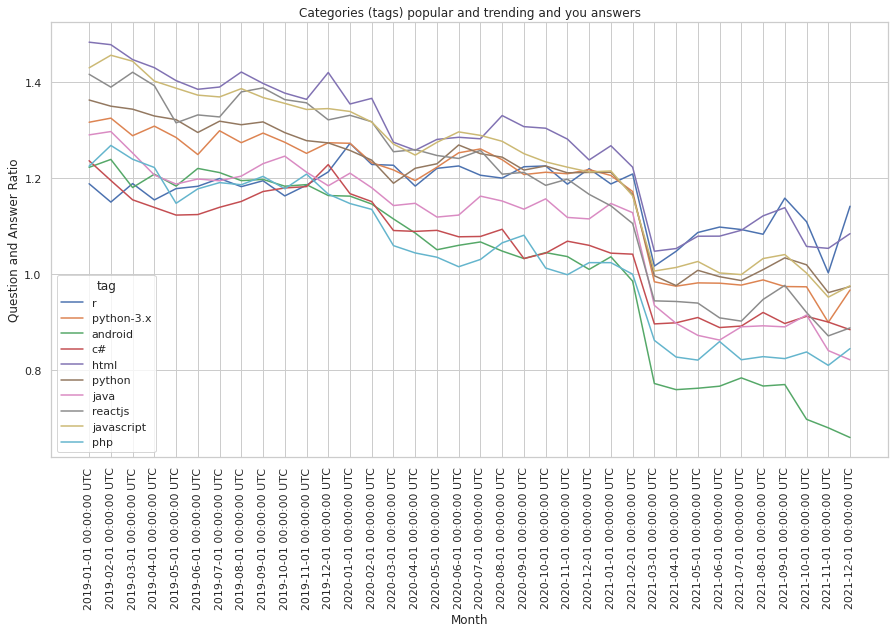

In [108]:
# Ordering the dataset
df7 = df7.sort_values(['datas'])

#Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
sns.lineplot(x = "datas", y = "ratio", hue = 'tag', data=df7)
plt.xlabel("Month")
plt.ylabel("Question and Answer Ratio")
plt.title("Categories (tags) popular and trending and you answers")
plt.xticks(rotation=90)